In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

#RGB Color channel
CHANNEL = 3

#number of times we will train the data
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage2",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 18163 files belonging to 13 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
#dataset is stored all the images in batch wise each batch contain 32 so len will be 68 ==> 68*32 = 2152+
len(dataset)

568

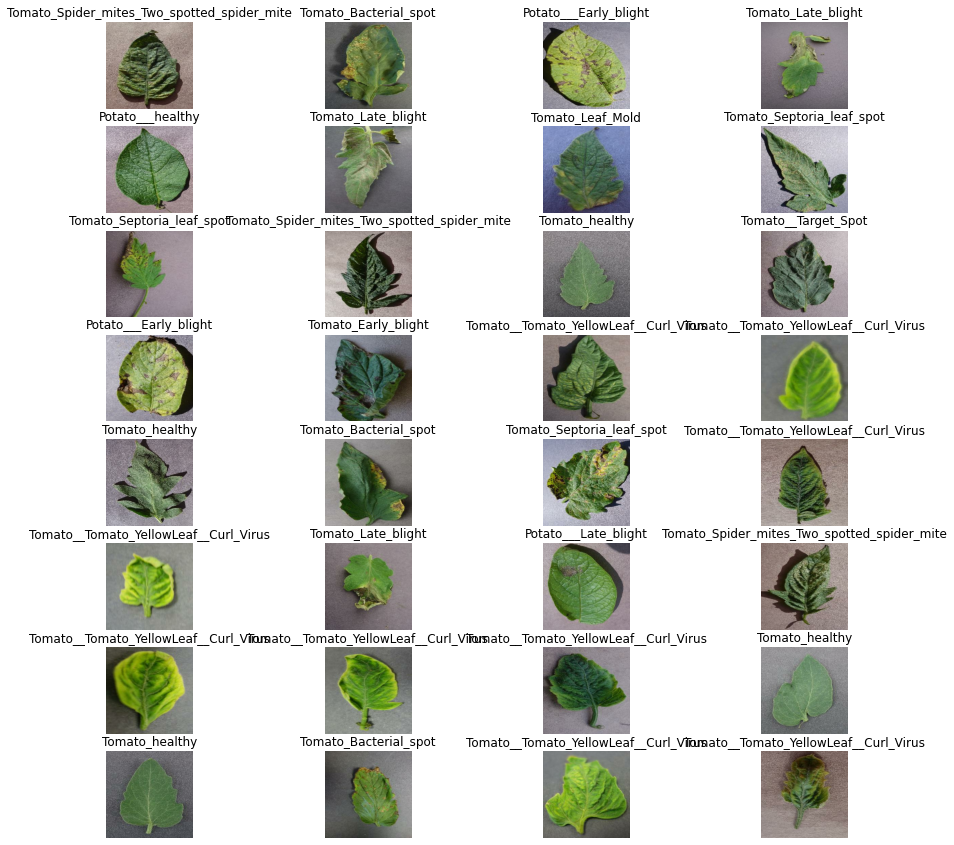

In [6]:
#to increase the area of plt
plt.figure(figsize=(15,15))

for image_batch, label_batch in dataset.take(1):
    
    #to display batch elements
    for i in range(32):
        
        #Dividing the plt to subplots here we want to display 32 to 8->rows and 4->cols ==> 32 subplots
        ax = plt.subplot(8,4,i+1)
        
        #to visualize the image
        #Here imshow() function expects 3d array(3d array size shape of image( 256px, 256px, 3rgb))
        #astype will convert the floating value to specified type here it is uint8
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        #plt title set by class of image using label_batch
        plt.title(class_names[label_batch[i]])
        
        #plt graph axis set to off
        plt.axis("off")

In [7]:
# Now we divide the data for sub purposes
# 80% ==> training
# 20% ==> 10%validation, 10%test
# for each epochs we do validation by using this 10% of data
# now after compeletion of all the epochs we will the remaing 10% of data to measure the accuracy of the model

In [8]:
train_size = 0.8
len(dataset)*train_size

454.40000000000003

In [9]:
train_ds = dataset.take(454)
len(train_ds)

454

In [10]:
test_ds = dataset.skip(454)
len(test_ds)

114

In [11]:
val_size = 0.1
len(dataset)*val_size

56.800000000000004

In [12]:
val_ds = test_ds.take(57)
len(val_ds)

57

In [13]:
test_ds = test_ds.skip(57)
len(test_ds)

57

In [14]:
#Now all the above operations must be incorporated into a function
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [16]:
len(train_ds)

454

In [17]:
len(val_ds)

56

In [18]:
len(test_ds)

58

In [19]:
#Now for improving the performance of pipeline we use cache() tf function
#cache stores already loaded data on to ram if it is need again there by reducing the load times
#prefetch is usefull in loading next set of batch to cpu when gpu is still processing the work
#tf.data.AUTOTUNE will automatically decide how many batches to load on to cpu by tensorflow
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#Now the data sets are optimized for training purposes

In [20]:
#Now we need to preprocessing.

#When ever we are working with images we need to scale the values to 0-1 basically images are rgb normally they are from 0-255.

#To sequential we will send our data.

#Why we are doing Resizing ==> while after training(prediciton stage) if we send any image of different size Resizing will 
#take care of it.

#To make our model robust we use augmentation techique.Why we need?==> if any image rotated or bad contrast augmentation will help.

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
#data augmentaion

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
#kernal size is size of the filter (3*3)
#filter = 1 for eye, 1 for nose, 1 for nose - image have head
#filter = 1 for legs, 1 for hands - image have body

#conv2D is convolutional layer
#after convolutional layer we have pooling

#Pooling =  we have different types of pooling 
#eg - max pooling = from matrix we take the max value

#Now by trail and error we must dedice how many convolutional and pooling layers we need and similar to 32 and 64s in conv2D

#Now we need to flatten the data

#Dense indicate connection with every output layers for single input layer
#softmax fucntion will normalize the propability of the classes

input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 13

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [24]:
#now compiling the model

model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
454/454 [==============================] - 821s 2s/step - loss: 1.8537 - accuracy: 0.3636 - val_loss: 1.6712 - val_accuracy: 0.4302
Epoch 2/30
454/454 [==============================] - 717s 2s/step - loss: 1.1584 - accuracy: 0.5976 - val_loss: 1.2788 - val_accuracy: 0.5949
Epoch 3/30
454/454 [==============================] - 706s 2s/step - loss: 0.7900 - accuracy: 0.7208 - val_loss: 1.1158 - val_accuracy: 0.6473
Epoch 4/30
454/454 [==============================] - 703s 2s/step - loss: 0.6137 - accuracy: 0.7861 - val_loss: 1.0056 - val_accuracy: 0.6936
Epoch 5/30
454/454 [==============================] - 762s 2s/step - loss: 0.5212 - accuracy: 0.8180 - val_loss: 1.0858 - val_accuracy: 0.6708
Epoch 6/30
454/454 [==============================] - 743s 2s/step - loss: 0.4386 - accuracy: 0.8471 - val_loss: 0.7452 - val_accuracy: 0.7673
Epoch 7/30
454/454 [==============================] - 752s 2s/step - loss: 0.3606 - accuracy: 0.8724 - val_loss: 0.5625 - val_accuracy: 0.8315

In [26]:
scores = model.evaluate(test_ds)

58/58 [==============================] - 68s 359ms/step - loss: 0.1937 - accuracy: 0.9376


In [27]:
scores

[0.1937495321035385, 0.9376017451286316]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 454}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

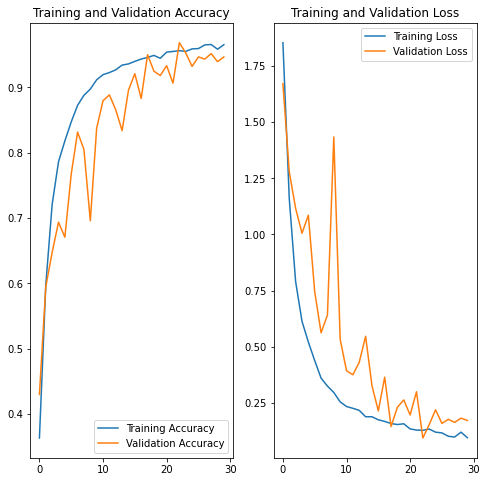

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: Tomato_healthy
1/1 [==============================] - 0s 338ms/step
predicted label:  Tomato_healthy


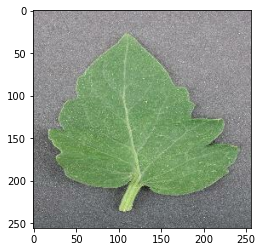

In [35]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction =  model.predict(images_batch)
    print("predicted label: " ,class_names[np.argmax(batch_prediction[0])])

In [36]:
#Fuction - Taking model and image and telling what is the predicted class and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


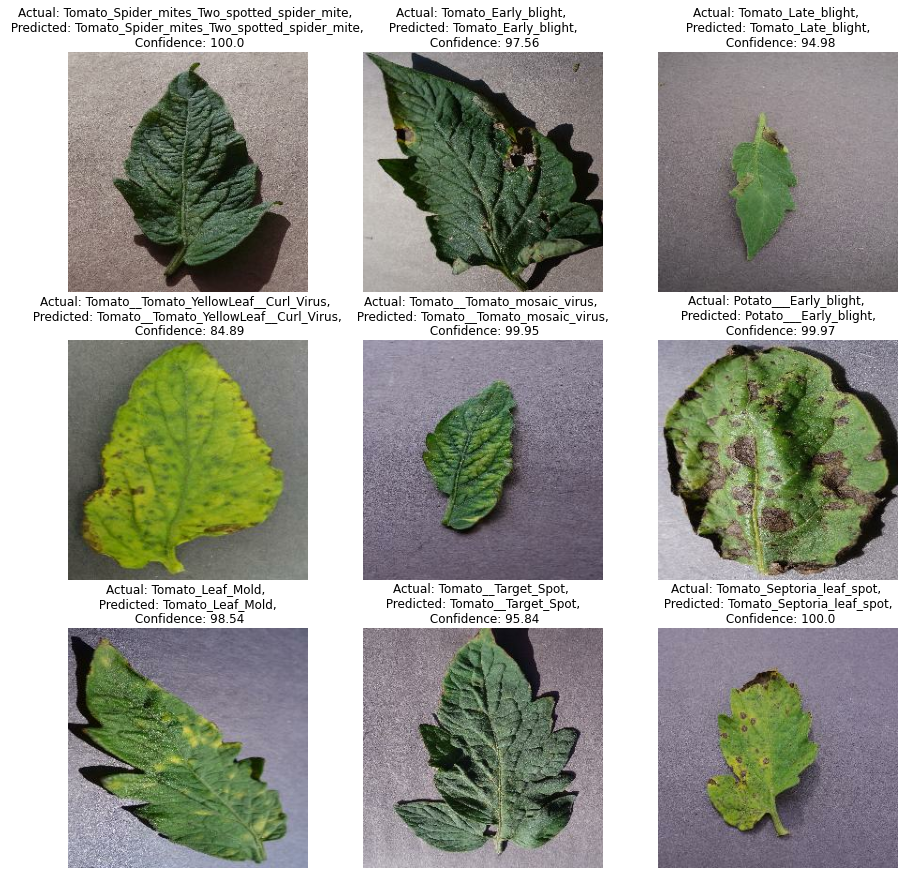

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
        
        plt.axis("off")

In [38]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models")]+[0])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets
